### Loads/inspects in the diseased donors in the Kuppe adata and makes it compatible for combining with other datasets

#### Kuppe et al. 2022 (Kramann Lab)

1. Technology: 10x 3' v3
2. Cell vs. nuclei: Nuclei only
3. Region: LV

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
from collections import Counter
import re
import scanpy.external as sce

In [2]:
def preprocess_adata(adata, donor_key, leiden_resolution):
    '''
    Performs: 
    1. library size normalization and log scaling
    2. identification of top 2K highly variable genes, 
    3. Principal component analysis
    4. Harmony integration
    5. Neighbor neighbors computation in Harmony integration embedding
    6. Leiden clustering 
    
    Parameters:
    adata (AnnData): adata object before preprocessing
    donor_key: the column in adata.obs that corresponds to the donor information (should be 'donor_id')
    leiden_resolution: resolution for leiden clustering, higher means more clusters will be detected

    Returns:
    adata: Postprocessed adata
    '''
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key=donor_key)
    sc.tl.pca(adata)
    sce.pp.harmony_integrate(adata, donor_key)
    sc.pp.neighbors(adata, use_rep = "X_pca_harmony")
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=donor_key, size=2)
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.5)
    return(adata)

Read in the Kuppe dataset

In [3]:
%%time
# load in the whole dataset
adata = sc.read_h5ad("01_updated_Kuppe_all.h5ad")

# filter only to the donors that are AMI or ICM (drop the CAD, HF)
adata = adata[adata.obs.disease.isin(["AMI", "ICM"]), :]
adata

CPU times: user 664 ms, sys: 3.9 s, total: 4.56 s
Wall time: 4.56 s


View of AnnData object with n_obs × n_vars = 140315 × 28975
    obs: 'cell_type', 'sex', 'donor_id', 'age', 'study', 'technology', 'cell_or_nuclei', 'region', 'disease', 'consistent_cell_type'
    var: 'feature_reference', 'feature_biotype', 'feature_length', 'ensembl_id'
    uns: 'X_approximate_distribution', 'batch_condition', 'cell_type_colors', 'cell_type_original_colors', 'citation', 'consistent_cell_type_colors', 'default_embedding', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'

In [4]:
# check that these are the raw counts (the sum of all values in the sparse matrix should be an integer value)
adata.X.sum(axis = 1)

matrix([[11584.],
        [ 2255.],
        [ 7718.],
        ...,
        [ 1277.],
        [ 1602.],
        [ 1748.]], dtype=float32)

In [5]:
%%time
donor_key = "donor_id"
# predict the doublets with scrublet
sc.pp.scrublet(adata, batch_key = donor_key)
num_doublets = adata[adata.obs.predicted_doublet == True].shape[0]
# filter out the doublets
adata = adata[adata.obs.predicted_doublet == False, :].copy()
print(f"Filtered out {num_doublets} likely doublets")

Filtered out 309 likely doublets
CPU times: user 43min 3s, sys: 37min 41s, total: 1h 20min 45s
Wall time: 17min 39s


2024-11-23 18:47:14,184 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-23 18:47:22,110 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-23 18:47:22,896 - harmonypy - INFO - Iteration 1 of 10
2024-11-23 18:48:38,994 - harmonypy - INFO - Iteration 2 of 10
2024-11-23 18:49:59,116 - harmonypy - INFO - Iteration 3 of 10
2024-11-23 18:51:16,525 - harmonypy - INFO - Converged after 3 iterations


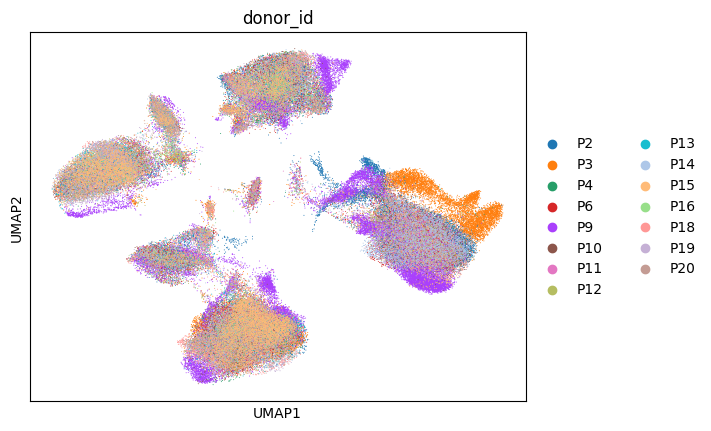

In [6]:
LEIDEN_RES = 0.5
adata = preprocess_adata(adata = adata, 
                         donor_key = "donor_id",
                         leiden_resolution = LEIDEN_RES)

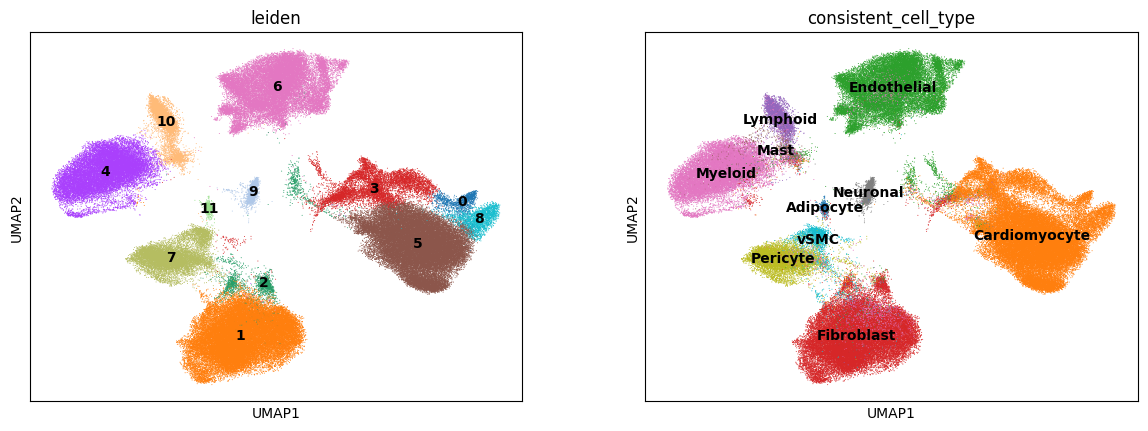

In [7]:
sc.pl.umap(adata, color=["leiden", "consistent_cell_type"], size=2, legend_loc = "on data")

In [8]:
set(adata.obs.consistent_cell_type)

{'Adipocyte',
 'Cardiomyocyte',
 'Endothelial',
 'Fibroblast',
 'Lymphoid',
 'Mast',
 'Myeloid',
 'Neuronal',
 'Pericyte',
 'vSMC'}

In [9]:
adata.write("02_processed_Kuppe_D.h5ad")